Machine Learning with Pytorch

PyTorch is an open source framework for AI research and commercial production in machine learning. It is used to build, train and optmize deep learning neural networks for applications such as image recognition, natural language processing, and speech recognition. It provides computation support for CPU, GPU, parallel and distributed training on multiple GPUs and multiple nodes. PyTorch is also flexible and easily extensible, with specific libraries and tools available for many different domains. All of the above have made PyTorch a leading framework in machine learning.

This lab shows you how easy is to get started with PyTorch and use it to build, train and evaluate a neural network.

Objectives

After completing this lab you will be able to:

    - Install necessary PyTorch libraries;
    - Use PyTorch to build, train and evaluate neural networks.
    - Save the trained model parameters and use them later for inferencing.


Setup

For this lab, we will be using the following libraries:

    - torch
    - TorchVision   

Importing Required Libraries

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

How does this lab work?

The lab uses MNIST datasets. The dataset has over 60,000 images of hand written digits. The data will be partitioned between training the AI model and testing the AI model after training.

The main steps in this project include:

1. Download the MNIST dataset and create a DataLoader for the dataset.
2. Define an AI model to recognize a hand written digit.
3. Train the defined AI model using training data from the MNIST dataset.
4. Test the trained AI model using testing data from the MNIST dataset.
5. Evaluate

Download Dataset and Create Data Loader

The images are 28x28 pixel images of digits 0 through 9.

In [12]:
# Download training data from the MNIST datasets.
training_data = datasets.MNIST(
    root="..\Pytorch\Datasets",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="..\Pytorch\Datasets",
    train=False, 
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders to iterate over data
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print("Training data size", len(train_dataloader) * batch_size)
print("Test data size:", len(test_dataloader) * batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Training data size 60032
Test data size: 10048
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Anthonny\AppData\Local\Temp\ipykernel_2832\2042593826.py:3: SyntaxWarning: invalid escape sequence '\P'
  root="..\Pytorch\Datasets",
C:\Users\Anthonny\AppData\Local\Temp\ipykernel_2832\2042593826.py:11: SyntaxWarning: invalid escape sequence '\P'
  root="..\Pytorch\Datasets",


Define Model

We first determine the best device for perfoming training with cpu as the default device.

We then define the AI model as a neural network with 3 layers: an input layer, a hidden layer, and an output layer.
Between the layers, we use ReLU activation function.

Since the input images are 1x28x28 tensors, we need to flatten the input tensors into a 784 element tensor using the Flatten module before passing the input into our neural network.

In [13]:
# Get device for training.
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() # Apple Silicon GPU
    else "cpu"
)
print(f"Using {device} device")

#Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, image_tensor):
        image_tensor = self.flatten(image_tensor)
        logits = self.linear_relu_stack(image_tensor)
        return logits
    
input_size = 28*28
hidden_size = 512
num_classes = 10

model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)


Using cpu device


Trainin Loop

We implement a training function to use with the train_dataloader to train our model. Each iteration over the dataloader returns a batch_size image data tensor along with the expected output. After moving the tensor to the device, we call the forward pass of our model, compute the predicition error using the expected output and then call the backwards pass to compute the gradients and apply them to the model parameters.

In [14]:
# Define our learning rate, loss function and optimizer
learning_rate = 1e-3 #0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Let's define our training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch_num, (X, y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)

        # Forward pass to compute prediction
        pred = model(X)
        # Compute prediction error using loss function
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad() # zero any previous gradient calculations
        loss.backward() # calculate gradient
        optimizer.step() # update model parameters

        if batch_num > 0 and batch_num % 100 == 0:
            loss, current = loss.item(), batch_num * len(X)
            print(f"loss : {loss:>7f}   [{current:>5d}/{size:>5d}]")

Test Loop

The test methods evaluates the model's predictive perfomance using the test_dataloader. During testing, we don't require gradient computation, so we set the model in evaluate mode.

In [15]:
# Our test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Train the Model

Now that we have defined methods to train our model and test the trained model's predictive behavior, lets train the model for 5 epochs over the dataset.

In [16]:
# Let's run training
epochs = 5
for t in range(epochs):
    print(f'Epoch {t+1}\n-----------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-----------------------
loss : 0.259129   [ 6400/60000]
loss : 0.193589   [12800/60000]
loss : 0.252482   [19200/60000]
loss : 0.128381   [25600/60000]
loss : 0.296876   [32000/60000]
loss : 0.131317   [38400/60000]
loss : 0.241594   [44800/60000]
loss : 0.252764   [51200/60000]
loss : 0.188765   [57600/60000]
Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000208 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000215 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000342 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000886 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.001046 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.001469 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000861 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.001113 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000643 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.001032 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.001343 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.001133 

Test Error: 
 Accuracy: 0.6%, Avg loss: 0.000702 

Test Error: 
 Acc

Save the Model

Once we have trained a model, we can save the model parameters for future use in inferences. Here we save the state_dict of the model which contains the trained parameters. We then create a new instance of the model and load the previously save parameters into the new instance of the model. Finally we can inference using the new instance of the model.

Saved PyTorch Model State to Pytorch\models\ml_with_pytorch_model.pth


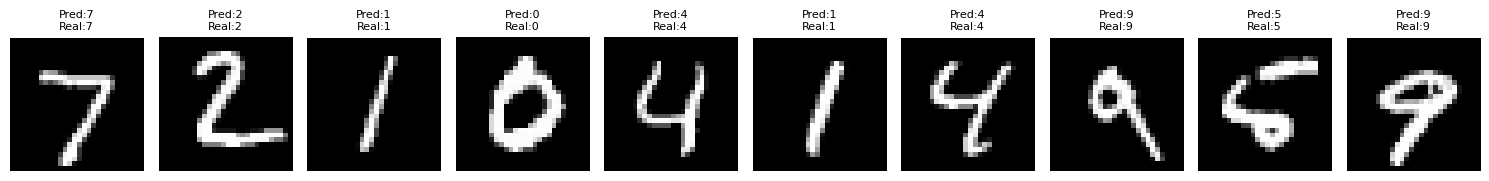

In [26]:
import matplotlib.pyplot as plt
# Salvar os pesos (state_dict) corretamente
torch.save(model.state_dict(), "../Pytorch/models/ml_with_pytorch_model.pth")
print("Saved PyTorch Model State to Pytorch\\models\\ml_with_pytorch_model.pth")

# Recriar a instância do modelo
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

# Carregar os pesos salvos
model.load_state_dict(torch.load("../Pytorch/models/ml_with_pytorch_model.pth", map_location=device))
# Usar o modelo para inferência
model.eval()

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    x, y = test_data[i][0], test_data[i][1]

    x_input = x.to(device)
    pred = model(x_input.unsqueeze(0)) # Adds batch dimension
    predicted = pred.argmax(1).item()
    
    axes[i].imshow(x.squeeze(), cmap='gray')
    axes[i].set_title(f'Pred:{predicted}\nReal:{y}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()